# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features
Some information about the data:

We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
There are 120 breeds of dogs (this means there are 120 different classes).
There are around 10,000+ images in the training set (these images have labels).
There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [44]:
# Unzip the uploaded data into Google Drive
# !unzip "data/dog-breed-identification.zip" -d "data/"

### Get our workspace ready
* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

In [45]:
# Import TensorFlow into Colab
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" # line needed to fix issue with tf.keras.Sequential issue

import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.16.1


In [46]:
# Checkut the labels of our data
import pandas as pd
labels_cvs = pd.read_csv("data/labels.csv")

print(labels_cvs.describe())
print(labels_cvs.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


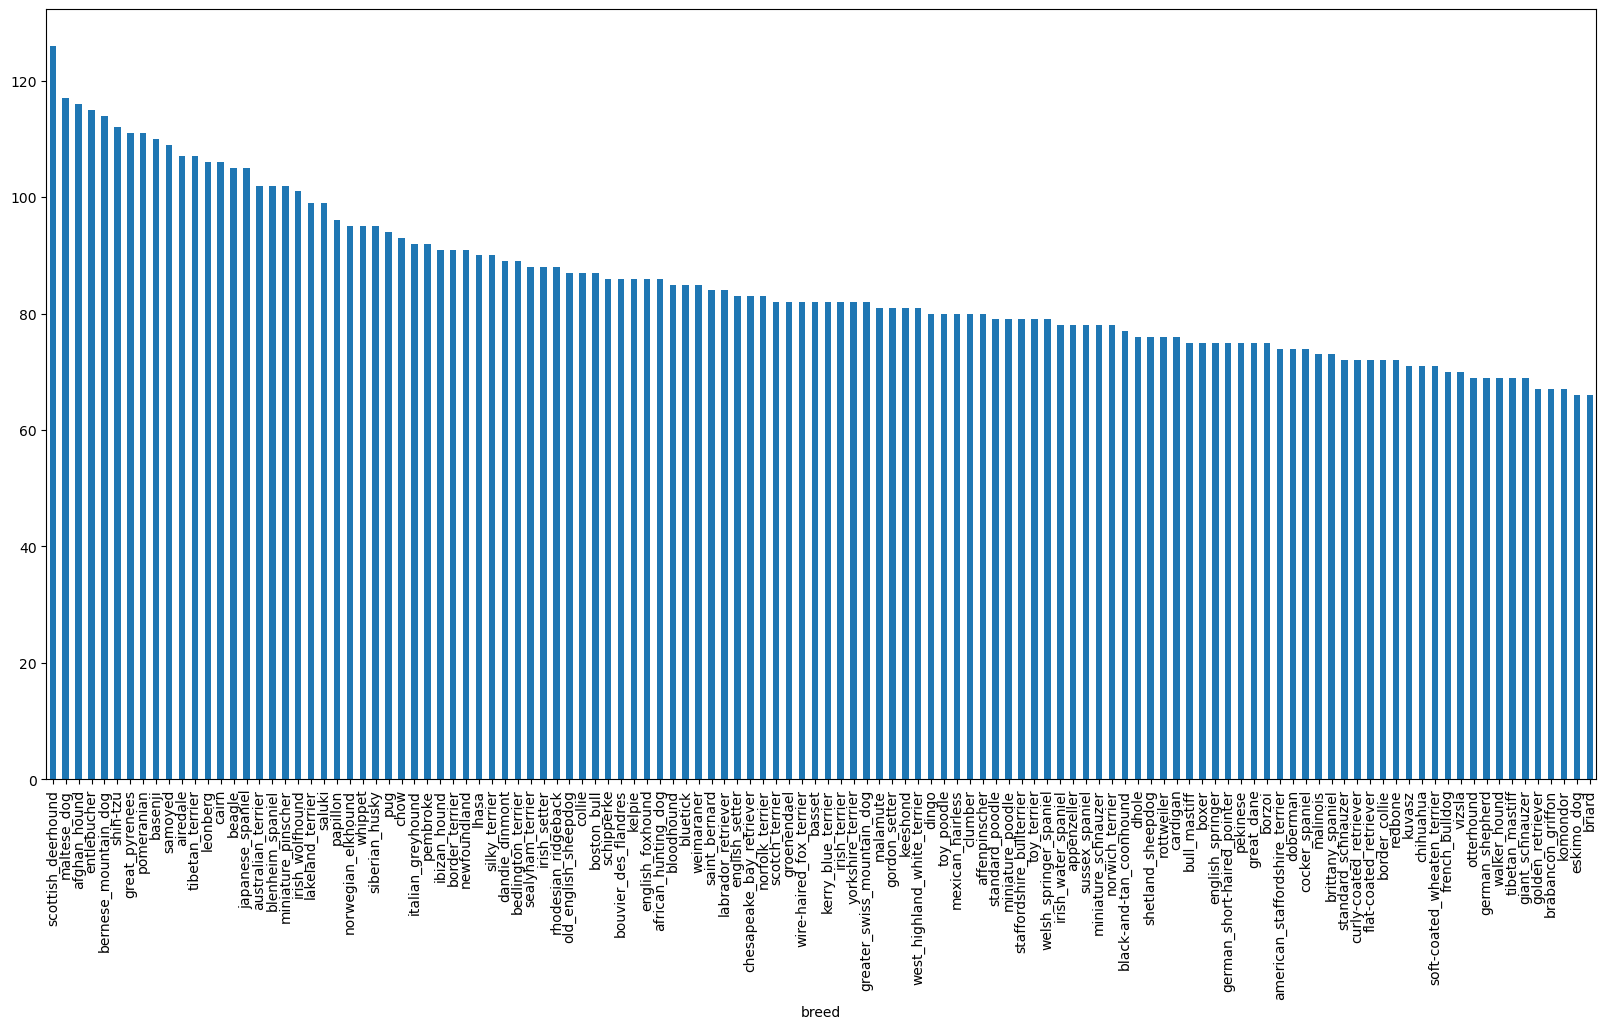

In [47]:
# How many images are there of each breed?
labels_cvs["breed"].value_counts().plot.bar(figsize=(20,10));

In [48]:
labels_cvs["breed"].value_counts().mean()

85.18333333333334

In [49]:
labels_cvs["breed"].value_counts().median()

82.0

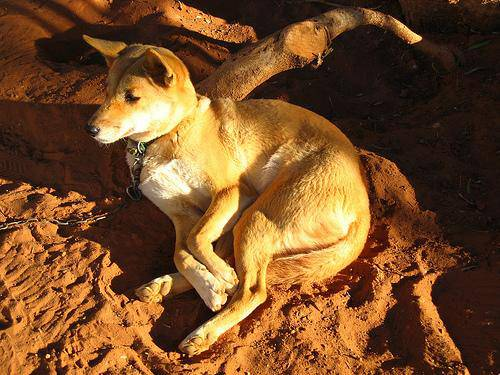

In [50]:
# Let's view an image
from IPython.display import Image
Image("data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of our image file pathnames.

In [51]:
labels_cvs.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [52]:
# Create pathname from image ID's
filenames = ["data/train/" + fname + ".jpg" for fname in labels_cvs["id"]]

# Check the first 10
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [53]:
# Check whether number of filenames matches number of actual image files
import os

if len(os.listdir("data/train")) == len(filenames):
  print("Filenames match actual amount of files! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files! Proceed.


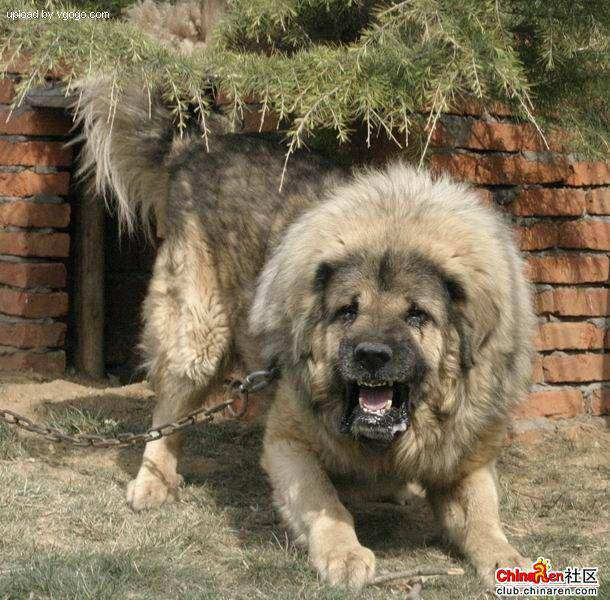

In [54]:
# One more check
Image(filenames[9000])

In [55]:
labels_cvs["breed"][9000]

'tibetan_mastiff'

### Since we've now got our training image filepaths in a list, let's prepare our labels.

In [56]:
import numpy as np

labels = labels_cvs["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [57]:
len(labels)

10222

In [58]:
# See if number of label matches the number of filenames

if len(labels) == len(filenames):
    print("Number of labels matches numbers of filenames!")
else:
    print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches numbers of filenames!


In [59]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [60]:
len(unique_breeds)

120

In [61]:
# Turn single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [62]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [63]:
len(boolean_labels)

10222

In [64]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where labels occurs
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the data from Kaggle doesn't come with validation set, we're going to create our own.

In [65]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [66]:
len(filenames)

10222

In [67]:
len(y)

10222

### We're going to start off experimenting with ~1000 images and increase as needed.

In [68]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [69]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [70]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

## Preprocessing Images (turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input.
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors.
4. Normalize our `image` (convert color channel values from from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224).
6. Return the modified `image`.

Before we do, let's see what importing an image looks like.

In [71]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [72]:
image.max(), image.min()

(255, 0)

In [73]:
# turn image into a tensor

tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [74]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(image, size=[img_size, img_size])
    return image

## Turning our data into batches
Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(tensor - here image, label)`.

In [75]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the assosciated label,
    processes the image and reutrns a typle of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [76]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: (`image`, `label`), let's make a function to turn all of our data (`X` & `y`) into batches!

In [77]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  # Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [78]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [79]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualize data batches


In [80]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.
We can do so by calling the `as_numpy_iterator()` method on a data batch.

This will turn our a data batch into something which can be iterated over.
Passing an iterable to `next()` will return the next item in the iterator.

 our case, next will return a batch of 32 images and label pairs.
Note: Running the cell below and loading images may take a little while.

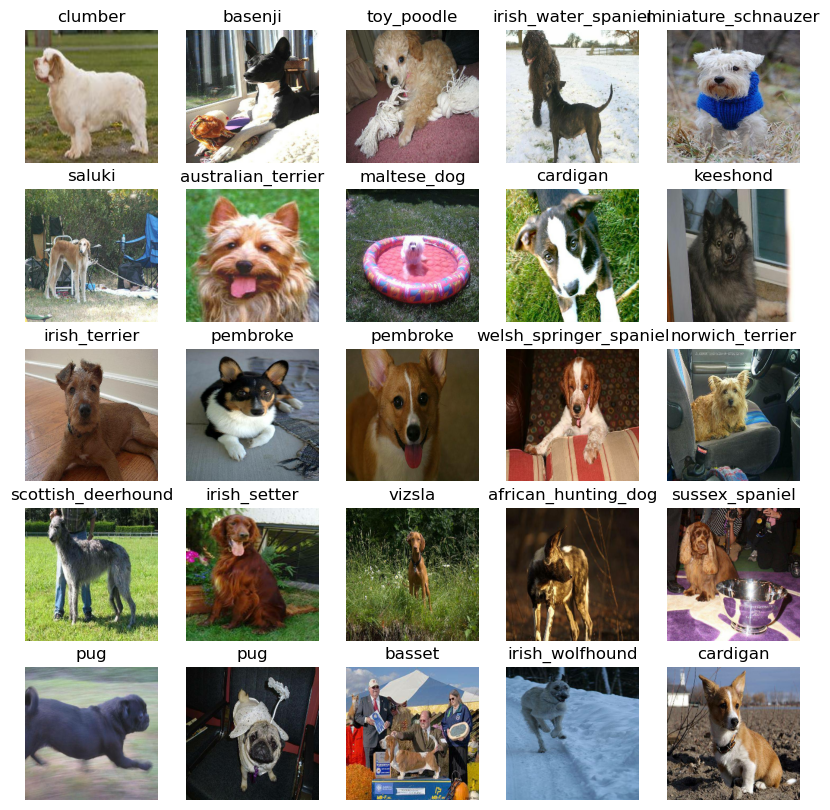

In [81]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

# Creating and training a model

Now our data is ready, let's prepare it modelling. We'll use an existing model from `TensorFlow Hub`.
TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.
Using a pretrained machine learning model is often referred to as transfer learning.
### Why use a pretrained model?
Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.

### How do we choose a model?
Since we know our problem is image classification (classifying different dog breeds), we can navigate the `TensorFlow Hub page by our problem domain (image)`.

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, `image classification`.

Doing this gives a list of different pretrained models we can apply to our task.

Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the `mobilenet_v2_130_224 model`, tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

Let's try it out.

## Building a model
Before we build a model, there are a few things we need to define:
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.
* These things will be standard practice with whatever machine learning model you use. And because we're using TensorFlow, everything will be in the form of Tensors.

In [82]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [83]:
import tensorflow_hub as hub
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [84]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback
To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function. ✅
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

In [85]:
# Load TensorBoard notebook extension

%load_ext tensorboard

In [87]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log ditectory
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [88]:
# Create early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [92]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [94]:
if tf.config.list_logical_devices("GPU"):
    print("JEST GPU")
else:
    print("NIE MA")

NIE MA


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [95]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [96]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


Epoch 1/100
25/25 [==============================] - 12s 227ms/step - loss: 4.5214 - accuracy: 0.0950 - val_loss: 3.3961 - val_accuracy: 0.2950
Epoch 2/100
25/25 [==============================] - 5s 215ms/step - loss: 1.5962 - accuracy: 0.6850 - val_loss: 2.0987 - val_accuracy: 0.5150
Epoch 3/100
25/25 [==============================] - 6s 222ms/step - loss: 0.5578 - accuracy: 0.9388 - val_loss: 1.6341 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 5s 221ms/step - loss: 0.2524 - accuracy: 0.9850 - val_loss: 1.4347 - val_accuracy: 0.6550
Epoch 5/100
25/25 [==============================] - 6s 226ms/step - loss: 0.1448 - accuracy: 0.9975 - val_loss: 1.3619 - val_accuracy: 0.6550
Epoch 6/100
25/25 [==============================] - 6s 235ms/step - loss: 0.0985 - accuracy: 1.0000 - val_loss: 1.3133 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================] - 5s 221ms/step - loss: 0.0742 - accuracy: 1.0000 - val_loss: 1.2849 - val_accuracy: 0.665

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [99]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6007 (pid 48857), started 0:01:10 ago. (Use '!kill 48857' to kill it.)

## Making and evaluating predictions using a trained model

In [100]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 2s 171ms/step


array([[5.8018812e-04, 1.2044067e-05, 5.2151759e-04, ..., 6.6847133e-04,
        7.1228227e-05, 4.7064847e-03],
       [2.7227500e-03, 6.5270322e-04, 3.3179598e-03, ..., 5.5182824e-04,
        1.5490865e-02, 1.7724092e-04],
       [4.1172858e-05, 9.2645467e-05, 5.3892327e-05, ..., 5.6908152e-06,
        2.6430585e-05, 2.8838275e-04],
       ...,
       [6.3692687e-06, 5.7576759e-05, 4.6587702e-05, ..., 4.5977208e-06,
        5.9563681e-05, 9.7727843e-06],
       [6.4081931e-03, 2.0115392e-04, 4.3695723e-04, ..., 3.8727000e-04,
        1.1760668e-04, 7.2237491e-03],
       [5.5985391e-04, 2.3064931e-04, 5.4090619e-03, ..., 8.8129602e-03,
        1.0186328e-03, 2.5223428e-05]], dtype=float32)

In [101]:
predictions.shape

(200, 120)

In [102]:
len(y_val)

200

In [103]:
len(unique_breeds)

120

In [107]:
# First prediction
index =42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[3.13229502e-05 5.22856571e-05 7.14236739e-06 1.32301884e-05
 1.38229760e-03 2.46234413e-05 9.01087624e-05 2.23831215e-04
 8.52584001e-03 2.30510198e-02 1.12179223e-05 6.87593047e-06
 3.58946301e-04 2.24573049e-03 1.05571840e-03 3.80201644e-04
 6.81254505e-06 2.80186621e-04 1.81139447e-04 1.06599990e-04
 1.92194420e-06 2.99023231e-04 1.89635557e-05 4.90913226e-05
 2.24955808e-02 3.64183070e-05 1.57638351e-04 2.02416282e-04
 5.06689721e-05 7.01315439e-05 1.90986411e-05 4.71927488e-05
 5.58016109e-05 2.19933681e-05 2.33592527e-05 1.42018007e-05
 9.38844241e-05 6.05959038e-04 8.06981334e-05 2.93440595e-02
 1.08632223e-04 3.26290392e-05 4.45730099e-03 3.78515142e-06
 5.24716568e-04 2.89359123e-05 1.65900317e-04 2.71066296e-04
 1.15353068e-05 8.17565888e-05 3.78629811e-05 4.38710886e-05
 6.54852192e-05 2.01979629e-03 4.26890210e-06 3.87439330e-04
 1.14039234e-04 2.44824587e-05 3.93158552e-05 2.18693622e-05
 2.05761862e-05 1.24663784e-04 7.31138357e-07 7.62359423e-06
 3.64895059e-05 1.366135

Having the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [108]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'irish_setter'

In [109]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [110]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

2024-06-16 23:17:56.452552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get get:

* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visaulize.

We'll create a function which:
1. Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
2. Convert the prediction probabilities to a predicted label. ✅
3. Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [119]:
def plot_preds(predictions_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n
    """
    pred_prob, true_label, image = predictions_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the colour of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    # Change plot title to be predicted, probability of prediction and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob)*100, true_label), color=color)

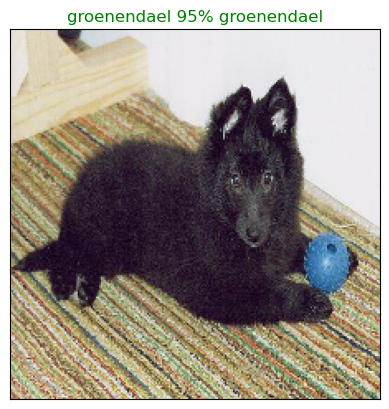

In [122]:
plot_preds(predictions_probabilities=predictions, labels=val_labels, images=val_images, n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
    * Prediction probabilities indexes ✅
    * Prediction probabilities values ✅
    * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [123]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), top_10_pred_values, color="grey")

  plt.xticks(np.arange(len(top_10_pred_labels)), labels=top_10_pred_labels, rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

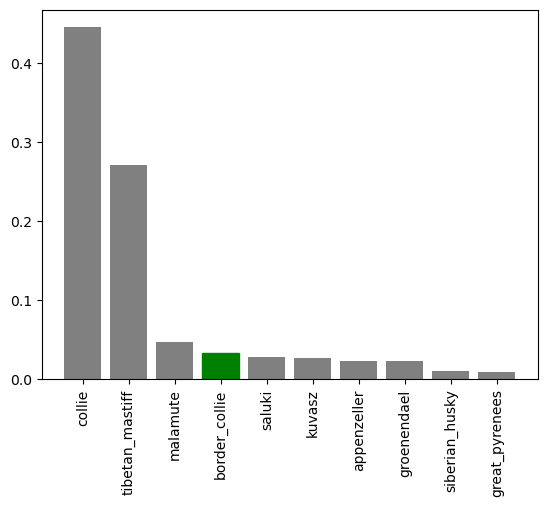

In [127]:
plot_pred_conf(prediction_probabilities=predictions, labels=val_labels, n=9)

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

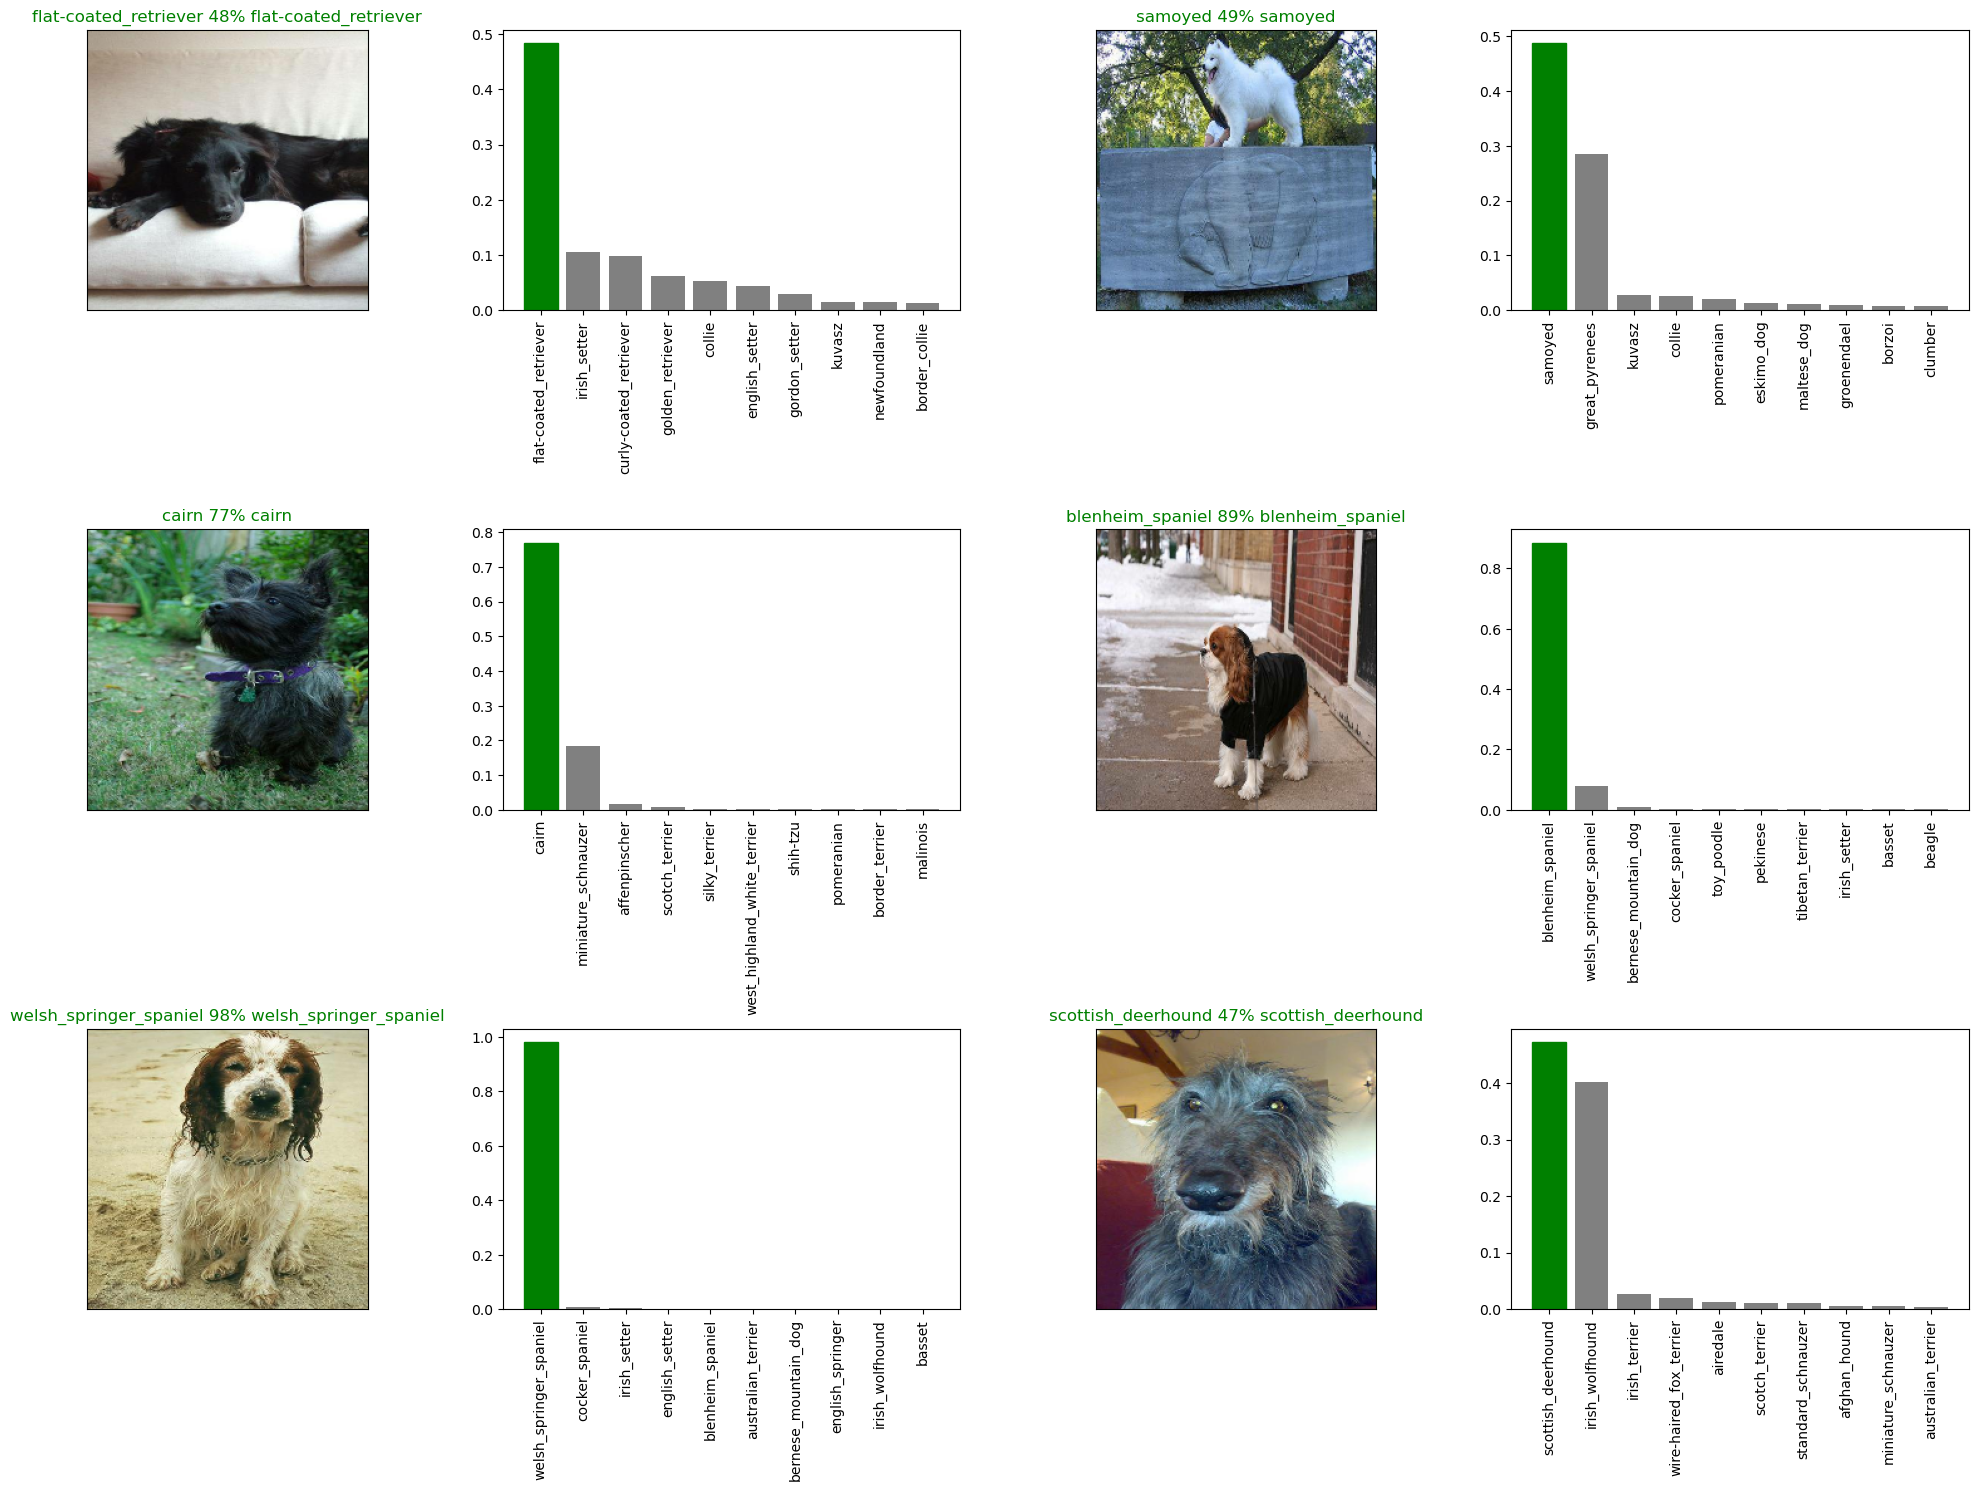

In [131]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10 * num_cols, 5 * num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  plot_preds(predictions_probabilities=predictions, labels=val_labels, images=val_images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions, labels=val_labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()